In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/santander-product-recommendation/sample_submission.csv.zip
/kaggle/input/santander-product-recommendation/test_ver2.csv.zip
/kaggle/input/santander-product-recommendation/train_ver2.csv.zip


In [ ]:
test = pd.read_csv("/kaggle/input/santander-product-recommendation/test_ver2.csv.zip",encoding="latin1", compression="zip")
test.head(2)

In [ ]:
sample = pd.read_csv("/kaggle/input/santander-product-recommendation/sample_submission.csv.zip",encoding="latin1", compression="zip")
sample.head(100)

In [3]:
df = pd.read_csv("/kaggle/input/santander-product-recommendation/train_ver2.csv.zip",encoding="latin1", compression="zip",nrows=10000)

Check all features' values to see exceptions and errors on data

In [4]:
for ft in df.columns:
    print(ft," : ",df[ft].unique()," : ",len(df[ft].unique()))

fecha_dato  :  ['2015-01-28']  :  1
ncodpers  :  [1375586 1050611 1050612 ... 1065719 1065649 1065648]  :  10000
ind_empleado  :  ['N' nan]  :  2
pais_residencia  :  ['ES' nan 'CA' 'CH' 'CL' 'IE']  :  6
sexo  :  ['H' 'V' nan]  :  3
age  :  [' 35' ' 23' ' 22' ' 24' ' 65' ' 28' ' 25' ' 26' ' 53' ' 27' ' 32' ' 37'
 ' 31' ' 39' ' 63' ' 33' ' 55' ' 42' ' 58' ' 38' ' 50' ' 30' ' 45' ' 44'
 ' 36' ' 29' ' 60' ' 57' ' 67' ' 47' ' NA' ' 34' ' 48' ' 46' ' 54' ' 84'
 ' 15' ' 12' '  8' '  6' ' 83' ' 40' ' 77' ' 69' ' 52' ' 59' ' 43' ' 10'
 '  9' ' 49' ' 41' ' 51' ' 78' ' 16' ' 11' ' 73' ' 62' ' 66' ' 17' ' 68'
 ' 82' ' 95' ' 96' ' 56' ' 61' ' 79' ' 72' ' 14' ' 19' ' 13' ' 86' ' 64'
 ' 20' ' 89' ' 71' '  7' ' 70' ' 74' ' 21' ' 18' ' 75' '  4' ' 80' ' 81'
 '  5' ' 76' ' 92' ' 93']  :  88
fecha_alta  :  ['2015-01-12' '2012-08-10' nan '2012-08-16' '2012-08-14' '2012-08-15'
 '2012-08-20' '2012-10-10' '2012-08-17' '2014-07-09' '2014-10-28'
 '2012-12-28' '2012-08-13' '2012-08-31' '2012-08-09' '2012-09-05'

1. ult_fec_cli_1t, : Last date as primary customer (if he isn't at the end of the month) -> deleting feature
1. conyuemp, : Spouse index. 1 if the customer is spouse of an employee                  -> filling with 0
1. renta, : Gross income of the household                                                -> (filling with AVG value)
1. canal_entrada : channel used by the customer to join                                  -> can't fill, delete feature or nans 
1. nomprov and cod_prov is null at same way                                              -> drop nan   
1. tiprel_1mes and indrel_1mes at same way                                               -> drop nan 

features contains a lot of nan variables. We can drop these features or fill nan values with any logic.    

* ncodpers              -> customer id, REMAIN SAME
* ind_empleado          -> 5 classes and a NAN ,ohe
* pais_residencia       -> 118 classes and a NAN, ohe
* sexo                  -> 2 classes and a NAN, ohe
* age                   -> have value 'NA' divide by 100 OR apply binning 
* fecha_alta            -> have NAN, date of beginning the journey of customer in bank
* ind_nuevo             -> 1 if customer is new and a NAN -> remain same
* antiguedad            -> the time customer is a customer, have NA and extreme numbers -99999 -> min max scale OR binning
* indrel                -> 2 classes 1, 9 and a NAN  
* ult_fec_cli_1t        -> date, have NAN
* indrel_1mes           -> 5 classes, 1,2,3,4,5,P , different type of values [1.0 nan 3.0 '1.0' '1' 'P' .. etc]  
* tiprel_1mes           -> 4 classes, ohe, have NAN and 'N'
* indresi               -> 2 classes, ohe, have NAN
* indext                -> 2 classes, ohe, have NAN
* conyuemp              -> 2 classes, ohe, have NAN (it means if it is a spurse of an employee)
* canal_entrada         -> 162 classes,have NAN, ohe or DIFFERENT ENCODING
* indfall               -> is dead, 2 classes (have NAN values), ohe
* tipodom               -> 2 classes, 1 or NAN, convert na to 0
* cod_prov              -> 53 classes with a NAN, ["52.","4."...]
* nomprov               -> province name, 53 classes, ohe OR DIFFERENT ENCODING
* ind_actividad_cliente -> 0 or 1 or NAN, delete NAN?
* renta                 -> income, scale OR binning
* segmento              -> 3 classes and NAN, ohe, delete NAN?
* ind_nomina_ult1       -> 0, 1 or NAN
* ind_nom_pens_ult1     -> 0, 1 or NAN
* others                -> REMAIN SAME  

## Handling NANs
* ind_empleado          -> fill with 'N' or delete
* pais_residencia       -> drop nan
* sexo                  -> drop nan
* age                   -> fill with most popular value 
* fecha_alta            -> delete, we mustn't use that feature anyway, we have antiguedad
* ind_nuevo             -> fill NAN with 1(new customer)
* antiguedad            -> fill 'NA' and negative numbers to 1
* indrel                -> fill NAN to 99 OR DELETE FEATURE   
* indresi               -> drop nan
* indext                -> drop nan
* indfall               -> fill nan as dead ('S')
* tipodom               -> fill nan to 0
* ind_actividad_cliente -> fill nan to 0 (not active) or drop  
* segmento              -> drop nan
* ind_nomina_ult1       -> drop nan
* ind_nom_pens_ult1     -> drop nan

### My Data Processing and Binning Functions

In [7]:
def processData(df,getDummies=True):
    data = df.copy()
    data.drop(columns=["ult_fec_cli_1t","canal_entrada"],inplace=True)
    data["conyuemp"] = data["conyuemp"].fillna('N')
    data["renta"] = data["renta"].fillna(data["renta"].mean())
    #Filling nan vlaues 
    def is_float(string):
      try:
        return float(string) or float(string)==0  
      except:  # String is not a number
        return False

    data["ind_empleado"] = data["ind_empleado"].fillna('N')

    data["age"] = data["age"].replace(' ', '', regex=True)
    data["age"] = data["age"].replace('.', '')

    data["age"] = data["age"].replace('NA',np.nan)
    data["age"] = data["age"].astype(float)

    data["ind_nuevo"] = data["ind_nuevo"].fillna(1)


    data["antiguedad"] = data["antiguedad"].replace(' ', '', regex=True)
    data["antiguedad"] = data.loc[:,"antiguedad"].replace("NA",1)
    data["antiguedad"] = data["antiguedad"].astype(int)
    data.loc[data.antiguedad<0,"antiguedad"] = 1    
    data["indfall"] = data["indfall"].fillna('S')
    data["tipodom"] = data["tipodom"].fillna(0)
    data["ind_actividad_cliente"] = data["ind_actividad_cliente"].fillna(0)
    data.drop(columns=["indrel","fecha_alta","nomprov"],inplace=True)
    data = data.dropna()    
    if(getDummies):
        data = pd.get_dummies(data, columns=['indresi','indext','conyuemp','indfall','sexo',
                                         'pais_residencia','ind_empleado','tiprel_1mes',
                                        "segmento"],drop_first=True)
    return data
def dataBin(df, getDummies=True):
    binned = df.copy()
    binned["renta"] = pd.qcut(binned["renta"], 3, labels=["low", "mid", "high"])
    binned["age"] = pd.cut(binned["age"], [0, 40, 80,200], labels=["low","mid","high"])
    binned["antiguedad"] = pd.cut(binned["antiguedad"], [0, 50, 150,250], labels=["low","mid","high"])
    if(getDummies):
        binned = pd.get_dummies(binned, columns=["renta","age","antiguedad","cod_prov"],drop_first=True)
    return binned


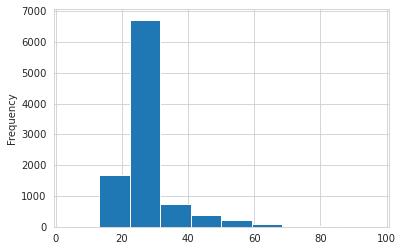

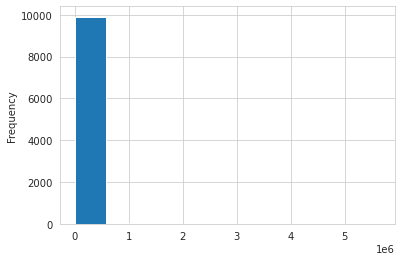

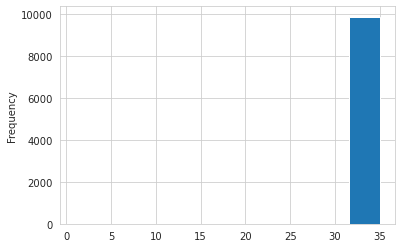

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
data = processData(df)
sns.set_style('whitegrid')
#Binning on renta, age, antiguedad
data['age'].plot(kind='hist')
plt.show()
data['renta'].plot(kind='hist')
plt.show()

data['antiguedad'].plot(kind='hist')
plt.show()

#age can be binned: 0-40, 40-80, 80+


In [9]:
data['antiguedad'].unique()

array([ 6, 35, 34, 33, 31, 21, 16, 27,  9, 22, 13, 29,  8, 11, 10, 28, 24,
        7, 25, 14, 26, 12, 23,  1, 18,  4,  3, 17])

Binning to renta, age and antiguedad

In [10]:
binned= dataBin(data)

ItemNames

In [11]:
ItemNames = ['ind_ahor_fin_ult1', 'ind_aval_fin_ult1', 'ind_cco_fin_ult1',
       'ind_cder_fin_ult1', 'ind_cno_fin_ult1', 'ind_ctju_fin_ult1',
       'ind_ctma_fin_ult1', 'ind_ctop_fin_ult1', 'ind_ctpp_fin_ult1',
       'ind_deco_fin_ult1', 'ind_deme_fin_ult1', 'ind_dela_fin_ult1',
       'ind_ecue_fin_ult1', 'ind_fond_fin_ult1', 'ind_hip_fin_ult1',
       'ind_plan_fin_ult1', 'ind_pres_fin_ult1', 'ind_reca_fin_ult1',
       'ind_tjcr_fin_ult1', 'ind_valo_fin_ult1', 'ind_viv_fin_ult1',
       'ind_nomina_ult1', 'ind_nom_pens_ult1', 'ind_recibo_ult1',]

Get Ratings By Sale Count

In [12]:
itemcols = ItemNames
itemcols.append("ncodpers") 

#binned
UserItemMatrix = df[itemcols]
UserItemMatrix = UserItemMatrix.groupby("ncodpers").sum() 
UserItemMatrix

,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,ind_cder_fin_ult1,ind_cno_fin_ult1,ind_ctju_fin_ult1,ind_ctma_fin_ult1,ind_ctop_fin_ult1,ind_ctpp_fin_ult1,ind_deco_fin_ult1,...,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
ncodpers,,,,,,,,,,,,,,,,,,,,,
1042162,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,0
1042163,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,0
1042165,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,0
1042166,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,0
1042167,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1065733,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,0
1065734,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,0
1065735,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,0


Set Ratings Dictionary 

In [13]:
ratings_dict = {
    "item": [],
    "user": [],
    "rating": [],
}
UserItemMatrix 

indexes = UserItemMatrix.index
items = UserItemMatrix.columns
for i in range(len(UserItemMatrix)):
    for j in range(len(items)):
        rating = UserItemMatrix.iloc[i,j]
        
        if(rating>0):
            ratings_dict[ "item" ].append(items[j])
            ratings_dict[ "user" ].append(indexes[i])
            ratings_dict["rating"].append(rating)
        else:
            ratings_dict[ "item" ].append(items[j])
            ratings_dict[ "user" ].append(indexes[i])
            ratings_dict["rating"].append(0)#UserItemMatrixCrop.iloc[:,j].mean())

Fine Tuning and Using SVD Collabrative Filtering algorithm using Scikit-Suprise 

In [14]:
from surprise import Reader, Dataset

max_rating = UserItemMatrix.max().values.max()
dfRatings = pd.DataFrame(ratings_dict)
reader = Reader(rating_scale=(0, max_rating))

data = Dataset.load_from_df(dfRatings[["user", "item", "rating"]], reader)

from surprise import SVD
from surprise.model_selection import GridSearchCV

param_grid = {
    "n_epochs": [1, 30],
    "lr_all": [0.002, 0.003],
    "reg_all": [0.4]
}
gs = GridSearchCV(SVD, param_grid, measures=["rmse", "mae"], cv=3,refit=True)
gs.fit(data)

print(gs.best_score["rmse"])
print(gs.best_params["rmse"])

0.12767338070619688
{'n_epochs': 1, 'lr_all': 0.002, 'reg_all': 0.4}


In [15]:
from surprise.model_selection import KFold
from surprise import accuracy
from surprise import KNNBasic

kf = KFold(n_splits=5)
sim_options = {'name': 'cosine',
               'user_based': True  # compute  similarities between items
               }
algo = SVD()

for trainset, testset in kf.split(data):

    # train and test algorithm.
    algo.fit(trainset)
    predictions = algo.test(testset)
    # Compute and print Root Mean Squared Error
    accuracy.mae(predictions, verbose=True)
    accuracy.rmse(predictions, verbose=True)

MAE:  0.0332
RMSE: 0.1164
MAE:  0.0319
RMSE: 0.1175
MAE:  0.0309
RMSE: 0.1167
MAE:  0.0313
RMSE: 0.1151
MAE:  0.0306
RMSE: 0.1161


In [ ]:
testPersons = test["ncodpers"]
submission = {"ncodpers":[],"added_products":[]}
for personid in testPersons.values:
    preds = ""
    for itemName in ItemNames:
        pred= gs.predict(personid,itemName)
        prob = pred[3]/max_rating
        if(prob>0.05):
            preds+= " " + itemName if preds != "" else itemName
    submission["ncodpers"].append(personid)
    submission["added_products"].append(preds)        
Submissiondf = pd.DataFrame(data=submission)  

In [ ]:
Submissiondf.set_index("ncodpers")
Submissiondf.to_csv("sub7MData5e-2.csv",index=False)

## TURICREATE AND INCLUDING USER INFORMATIONS

Drop date and items to get user information

In [20]:
featuresNotUserInfo = ['ind_ahor_fin_ult1', 'ind_aval_fin_ult1', 'ind_cco_fin_ult1',
       'ind_cder_fin_ult1', 'ind_cno_fin_ult1', 'ind_ctju_fin_ult1',
       'ind_ctma_fin_ult1', 'ind_ctop_fin_ult1', 'ind_ctpp_fin_ult1',
       'ind_deco_fin_ult1', 'ind_deme_fin_ult1', 'ind_dela_fin_ult1',
       'ind_ecue_fin_ult1', 'ind_fond_fin_ult1', 'ind_hip_fin_ult1',
       'ind_plan_fin_ult1', 'ind_pres_fin_ult1', 'ind_reca_fin_ult1',
       'ind_tjcr_fin_ult1', 'ind_valo_fin_ult1', 'ind_viv_fin_ult1',
       'ind_nomina_ult1', 'ind_nom_pens_ult1', 'ind_recibo_ult1',"fecha_dato"]
data = processData(df.drop(columns=featuresNotUserInfo),getDummies = False)
data = dataBin(data,getDummies= False)
userInfo = data.groupby("ncodpers").last()
userInfo = userInfo.reset_index()

userInfo.rename(columns={"ncodpers":"user_id"},inplace=True)
userInfo = userInfo.to_dict()

Create and Train Recommender System

In [17]:
!pip install turicreate
import turicreate as tc

SF_userInfo = tc.SFrame(userInfo)
#!pip install turicreate
turiDict = {}
turiDict["item_id"] = ratings_dict["item"]
turiDict["user_id"] = ratings_dict["user"]
turiDict["rating"] = ratings_dict["rating"]
actions  = tc.SFrame(turiDict)
training_data, validation_data = tc.recommender.util.random_split_by_user(actions)
model = tc.recommender.create(training_data,target='rating',user_data=SF_userInfo)



     |████████████████████████████████| 91.9 MB 6.6 MB/s eta 0:00:011
     |████████████████████████████████| 3.5 MB 33.8 MB/s eta 0:00:01
     |████████████████████████████████| 322 kB 31.7 MB/s eta 0:00:01
     |████████████████████████████████| 86.3 MB 113 kB/s  eta 0:00:01
     |████████████████████████████████| 449 kB 38.1 MB/s eta 0:00:01
     |████████████████████████████████| 50 kB 3.6 MB/s  eta 0:00:01
     |████████████████████████████████| 3.8 MB 33.1 MB/s eta 0:00:01
  Created wheel for resampy: filename=resampy-0.2.1-py3-none-any.whl size=320848 sha256=221542e5cd574f53df6d79c3aa966bc00f3b46349fe5d846ccd78dbd0bf5c42f
  Stored in directory: /root/.cache/pip/wheels/71/74/53/d5ceb7c5ee7a168c7d106041863e71ac3273f4a4677743a284
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7539 sha256=0da99c2dec794e837a3ee71a3aba7e29113ab531275db323062d1ff0464c50c9
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Succ

  Attempting uninstall: gast
    Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninstalled tensorboard-2.3.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.3.0
    Uninstalling tensorflow-2.3.0:
      Successfully uninstalled tensorflow-2.3.0
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

tensorflow-probability 0.11.0 requires gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
librosa 0.8.0 requires resampy>=0.2.2, but you'll have resampy 0.2.1 which is incompatible.
You should consider upgradi

Preparing data set.

Data has 235247 observations with 19946 users and 24 items.

Data prepared in: 0.21601s

Training ranking_factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 32       |

| regularization                 | L2 Regularization on Factors                     | 1e-09    |

| solver                         | Solver used for training                         | adagrad  |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-09    |

| ranking_regularization         | Rank-based Regularization Weight                 | 0.25     |

| side_data_factorization        | Assign Factors for Side Data                     | True     |

| max_iterations                 | Maximum Number of Iterations                     | 25       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 29405 / 235247 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 2.63158           | Not Viable                               |

| 1       | 0.657895          | 0.0887689                                |

| 2       | 0.328947          | 0.0502351                                |

| 3       | 0.164474          | 0.032724                                 |

| 4       | 0.0822368         | 0.00582501                               |

| 5       | 0.0411184         | 0.00353435                               |

| 6       | 0.0205592         | 0.011906                                 |

+---------+-------------------+------------------------------------------+

| Final   | 0.0411184         | 0.00353435                               |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 163us        | 0.0512331         | 0.217995              |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 143.963ms    | 0.0137282         | 0.112766              | 0.0411184   |

| 2       | 274.93ms     | 0.00745959        | 0.0814294             | 0.0411184   |

| 3       | 417.249ms    | 0.00416719        | 0.0592546             | 0.0411184   |

| 4       | 567.753ms    | 0.00311993        | 0.0508095             | 0.0411184   |

| 5       | 710.308ms    | 0.00220081        | 0.0416449             | 0.0411184   |

| 10      | 1.38s        | 0.000595999       | 0.0176089             | 0.0411184   |

| 25      | 4.20s        | 0.000218396       | 0.00948378            | 0.0411184   |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.00100997

Final training RMSE: 0.00865641

Save recommender Model

In [22]:
model

AttributeError: 'RankingFactorizationRecommender' object has no attribute 'rmse'

In [ ]:
model.save("recommendations.model")


Check Item Similarity

In [18]:
ItemNames = ['ind_ahor_fin_ult1', 'ind_aval_fin_ult1', 'ind_cco_fin_ult1',
       'ind_cder_fin_ult1', 'ind_cno_fin_ult1', 'ind_ctju_fin_ult1',
       'ind_ctma_fin_ult1', 'ind_ctop_fin_ult1', 'ind_ctpp_fin_ult1',
       'ind_deco_fin_ult1', 'ind_deme_fin_ult1', 'ind_dela_fin_ult1',
       'ind_ecue_fin_ult1', 'ind_fond_fin_ult1', 'ind_hip_fin_ult1',
       'ind_plan_fin_ult1', 'ind_pres_fin_ult1', 'ind_reca_fin_ult1',
       'ind_tjcr_fin_ult1', 'ind_valo_fin_ult1', 'ind_viv_fin_ult1',
       'ind_nomina_ult1', 'ind_nom_pens_ult1', 'ind_recibo_ult1',]

In [19]:
model.get_similar_items(ItemNames, k=24)

item_id,similar,score,rank
ind_ahor_fin_ult1,ind_pres_fin_ult1,0.9875945448875427,1
ind_ahor_fin_ult1,ind_hip_fin_ult1,0.9535534381866455,2
ind_ahor_fin_ult1,ind_ctop_fin_ult1,0.4190506339073181,3
ind_ahor_fin_ult1,ind_deco_fin_ult1,0.3097928464412689,4
ind_ahor_fin_ult1,ind_viv_fin_ult1,0.22804200649261475,5
ind_ahor_fin_ult1,ind_cder_fin_ult1,0.19561275839805603,6
ind_ahor_fin_ult1,ind_aval_fin_ult1,0.1757592260837555,7
ind_ahor_fin_ult1,ind_deme_fin_ult1,0.11837621033191681,8
ind_ahor_fin_ult1,ind_ctpp_fin_ult1,0.05505124479532242,9
ind_ahor_fin_ult1,ind_plan_fin_ult1,0.0021328905131667852,10


In [ ]:
testPersons = test["ncodpers"]
#Recommendation skorları
recommendations = model.recommend(testPersons.values)
submission = {"ncodpers":[],"added_products":[]}

#0.9 thresholddakilerin üstü alınır
users = recommendations[recommendations["score"]>0.9]

#Test dosyasındak her user için, öneri skorlarında o user id'ye denk gelen itemleri ekle
for id in testPersons.values:
    submission["ncodpers"].append(id)
    itemsOfUser = users[users["user_id"]==id]["item_id"]
    
    #userların alacağı tüm itemleri boşluk ile ayırıp string haline getir
    itemString = ""
    for item in itemsOfUser:
        itemString += " "+item
        
    print(id," : ",itemString)    
    submission["added_products"].append(itemString)  
Submissiondf = pd.DataFrame(data=submission)  

In [ ]:
Submissiondf.head(5)

In [ ]:
Submissiondf.set_index("ncodpers")
Submissiondf.to_csv("turicreate.csv",index=False)